# Titanic: Machine Learning from Disaster

### Import Libraries

In [102]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import uniform

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

### Load Data

In [2]:
df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

### Visualize data before cleanup

In [3]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Analysis and Cleanup

* https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-1-exploratory-data-analysis-with-pandas-de57880f1a68
* https://www.datacamp.com/community/tutorials/exploratory-data-analysis-python

In [4]:
# Shape of dataset, including generated columns
df.shape

(891, 12)

In [5]:
# What are our columns, again?
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
# General information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Missing Values

* https://analyticsindiamag.com/5-ways-handle-missing-values-machine-learning-datasets/

In [9]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Cabin

Unfortunately, over 77% of Cabin info is missing in the dataset. Discarding data which does not have cabin data is out of the question. Also, survival may have been affected by which cabin a person was in and consequently which deck they were on, when the Titanic sank. While we could set it to a new value like `U`, a better way would be to analyse the deck structure of RMS Titanic and assign cabins by class.

A cursory read-through of how Titanic's cabins were organized in Wikipedia gives the following insights:
* A-Deck: It was reserved exclusively for First Class passengers
* B-Deck: More First Class passenger accommodations were located here 
* C-Deck: Crew Cabins
* D-Deck: First, Second and Third Class passengers had cabins on this deck
* E-Deck: The majority of E-Deck was occupied by Second-Class
* F-Deck: Second and Third Class passengers

So, let us assign decks based on a passenger's class in the following way:
* First Class: Random assignment beteween A and B Decks
* Second Class: Random assignment between D and E Decks
* Third Class: Random assignment between E, F and G Decks

While we are at it, let's also convert values in Cabin column to Decks, because that's a better feature for our analysis.

In [10]:
# Convert Cabins to Decks
def convert_to_deck(cabin):
    if not pd.isna(cabin):
        cabin = cabin[0]
    return cabin

df['Deck'] = df['Cabin'].apply(convert_to_deck)

In [11]:
# Remove the odd value 'T' in Cabin/Deck
df = df[df['Deck'] != 'T']

In [12]:
# Random assignment of Decks for passengers with no Cabin info
for i, row in df[df['Cabin'].isnull()].iterrows(): 
    if row['Pclass'] == 1:
        df.at[i, 'Deck'] = random.choice(['A', 'B'])
    elif row['Pclass'] == 2:
        df.at[i, 'Deck'] = random.choice(['D', 'E'])
    else:
        df.at[i, 'Deck'] = random.choice(['E', 'F', 'G'])

In [13]:
# Drop cabin from the dataset
df = df.drop('Cabin', axis=1)

#### Embarked

Most passengers boarded Titanic at Southampton (923, vs. 274 in Cherbourg and 123 in Queenstown). Let's just assign the missing `Embarked` values to `S` for Southampton.

In [14]:
# Update null values in Embarked to S

df['Embarked'].fillna('S', inplace=True)

In [15]:
# Also replace Embarked with numeric values
df.loc[df['Embarked'] == 'S', 'Embarked'] = 0
df.loc[df['Embarked'] == 'C', 'Embarked'] = 1
df.loc[df['Embarked'] == 'Q', 'Embarked'] = 2

print(df['Embarked'].unique())
print(df['Embarked'].value_counts())

[0 1 2]
0    645
1    168
2     77
Name: Embarked, dtype: int64


#### Age

The age of passengers is a very important attribute for our analysis, as Children were among the group of people onboard with a higher chance of survival (others being Women and Upper class). Removing records with no age information (~20% of the dataset) is not an option, neither is replacing the age with mean, median or mode. Let's use the age values we have from the other 80% of data to predict the missing 20%.

In [16]:
# Use Pandas Dataframe Interpolate to fill missing values!
df = df.interpolate()

In [17]:
# Or take the longer way to predict missing Age values
if df['Age'].isnull().sum() > 0:
    linear = LinearRegression()

    data_with_null = df[df['Age'].isnull()][['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'Embarked']]
    data_without_null = df[['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'Embarked']].dropna()

    age_train_X = data_without_null.drop('Age', axis=1)
    age_train_y = data_without_null['Age']

    # FIXME - Does the presence of PassengerId affect fit?
    linear.fit(age_train_X, age_train_y)

    age_predicted = data_with_null
    age_test_X = data_with_null.drop('Age', axis=1)

    age_predicted['Age'] = linear.predict(age_test_X)

    # https://stackoverflow.com/questions/41773728/pandas-fill-na-with-data-from-another-dataframe-based-on-same-id
    df_cleaned = df.set_index("PassengerId").combine_first(age_predicted.set_index("PassengerId")).reset_index()

    # Set Negative age to a particular value, say 5 years
    df.loc[df['Age'] < 0., 'Age'] = 5

### Outliers

* https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
* https://statinfer.com/104-3-5-box-plots-and-outlier-dectection-using-python/

#### Fare

{'whiskers': [<matplotlib.lines.Line2D at 0x115ab7128>,
 'caps': [<matplotlib.lines.Line2D at 0x115ab79e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x115aacf98>],
 'medians': [<matplotlib.lines.Line2D at 0x115ac6278>],
 'fliers': [<matplotlib.lines.Line2D at 0x115ac66a0>],
 'means': []}

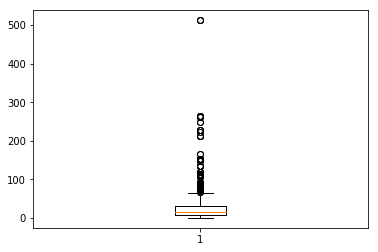

In [18]:
plt.boxplot(df['Fare'])

In [19]:
# Remove outliers in Fare values
# Get relevant percentiles and see their distribution
df['Fare'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0      0.00000
0.1      7.55000
0.2      7.85420
0.3      8.05000
0.4     10.50000
0.5     14.45420
0.6     21.31668
0.7     27.00000
0.8     39.68750
0.9     77.95830
1.0    512.32920
Name: Fare, dtype: float64

In [20]:
# Calculate 25th and 75th percentile, and the InterQuartile Range (IQR)
fare_q25, fare_q75 = np.percentile(df['Fare'], 25), np.percentile(df['Fare'], 75)
fare_iqr = fare_q75 - fare_q25
fare_iqr

23.096899999999998

In [21]:
# Find the lower and upper limits
cutoff = fare_iqr * 10 # 10 is too high a value. Usually, values above or below 1.5 times IQR are deemed acceptable
lower, upper = max(fare_q25 - cutoff, 0), fare_q75 + cutoff
print("Lower: {}, Upper: {}".format(lower, upper))

Lower: 0, Upper: 261.969


In [22]:
# Observe Outliers
df[(df['Fare'] < lower) | (df['Fare'] > upper)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,0,C
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,0,C
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,1,A
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,1,B
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,0,C
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,0,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,1,B
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,1,B
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,1,B


On deeper analysis, the outlier fares seem to be valid and belonging to 3 ticket numbers. Let's keep all Fare values and not remove any outliers.

#### Age

{'whiskers': [<matplotlib.lines.Line2D at 0x115b37da0>,
 'caps': [<matplotlib.lines.Line2D at 0x115b3f6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x115b37c50>],
 'medians': [<matplotlib.lines.Line2D at 0x115b3fef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x115b47358>],
 'means': []}

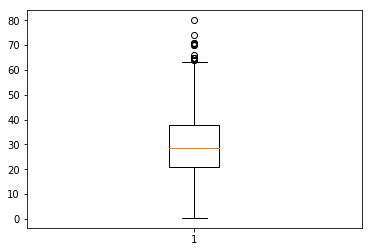

In [23]:
plt.boxplot(df['Age'])

**Age** seems to be distributed well, so let us not eliminate any outliers.

### Data Preparation

#### Sex

Change 'female' and 'male' values to 0 and 1 respectively.

In [24]:
df['Sex'].replace({'female':0,'male':1},inplace=True)
print(df['Sex'].unique())
print(df['Sex'].value_counts())

[1 0]
1    576
0    314
Name: Sex, dtype: int64


#### Deck

Change A-G decks with numeric values

In [25]:
print(df['Deck'].unique())
print(df['Deck'].value_counts())
df['Deck'].replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], [0, 1, 2, 3, 4, 5, 6, 7], inplace=True)
print(df['Deck'].unique())
print(df['Deck'].value_counts())

['G' 'C' 'E' 'F' 'D' 'A' 'B']
E    275
F    188
G    156
D    110
B     64
C     59
A     38
Name: Deck, dtype: int64
[6 2 4 5 3 0 1]
4    275
5    188
6    156
3    110
1     64
2     59
0     38
Name: Deck, dtype: int64


#### Miscellaneous columns

Drop **PassengerId**, **Ticket** and **Name** columns

In [26]:
df = df.drop(['Name', 'PassengerId', 'Ticket'], axis=1)

In [27]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,0,3,1,22.0,1,0,7.2500,0,6
1,1,1,0,38.0,1,0,71.2833,1,2
2,1,3,0,26.0,0,0,7.9250,0,4
3,1,1,0,35.0,1,0,53.1000,0,2
4,0,3,1,35.0,0,0,8.0500,0,5


In [28]:
# Separate data and target values
y = df['Survived']
df = df.drop('Survived', axis=1)

## Feature Selection

* https://machinelearningmastery.com/feature-selection-machine-learning-python/

### Univariate Selection

In [29]:
kbest = SelectKBest(score_func=chi2, k=4)
kbest_fit = kbest.fit(df, y)

# Summarize Scores
pd.options.display.float_format = "{:.2f}".format
print(kbest_fit.scores_)

features = kbest_fit.transform(df)
print(features[0:5,:])

[3.11295582e+01 9.26007474e+01 2.16936333e+01 2.64263585e+00
 9.98961888e+00 4.52407258e+03 1.12413776e+01 4.11719177e+01]
[[ 3.      1.      7.25    6.    ]
 [ 1.      0.     71.2833  2.    ]
 [ 3.      0.      7.925   4.    ]
 [ 1.      0.     53.1     2.    ]
 [ 3.      1.      8.05    5.    ]]


In [30]:
# Determine which features were chosen
mask = kbest_fit.get_support() #list of booleans
univariate_new_features = [] # The list of your K best features
feature_names = list(df.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        univariate_new_features.append(feature)

In [31]:
univariate_new_features

['Pclass', 'Sex', 'Fare', 'Deck']

### Recursive Feature Elimination

In [32]:
linear_model = LinearRegression()
rfe = RFE(linear_model, 4)
rfe_fit = rfe.fit(df, y)
print("Num Features: %d" % (rfe_fit.n_features_))
print("Selected Features: %s" % (rfe_fit.support_))
print("Feature Ranking: %s" % (rfe_fit.ranking_))

Num Features: 4
Selected Features: [ True  True False  True False False  True False]
Feature Ranking: [1 1 4 1 3 5 1 2]


/Users/subhashb/.pyenv/versions/3.6.5/envs/100-days/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [33]:
# Determine which features were chosen
mask = rfe_fit.support_ #list of booleans
recursive_new_features = [] # The list of your K best features
feature_names = list(df.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        recursive_new_features.append(feature)

In [34]:
recursive_new_features

['Pclass', 'Sex', 'SibSp', 'Embarked']

### PCA

In [35]:
pca = PCA(n_components=4)
pca_fit = pca.fit(df, y)

print("Explained Variance: %s" % (pca_fit.explained_variance_ratio_))
print("Components:", pca_fit.components_)

Explained Variance: [9.26424714e-01 7.18378376e-02 8.37760270e-04 4.38249448e-04]
Components: [[-9.27637200e-03 -1.74838374e-03  2.64186790e-02  3.50393505e-03
   3.48317128e-03  9.99463105e-01  7.96668637e-04 -1.61679533e-02]
 [-1.53694329e-02  2.70027064e-03  9.98963978e-01 -1.84011299e-02
  -1.11925580e-02 -2.68504514e-02  9.84568614e-04 -2.53311607e-02]
 [ 3.57220512e-01 -1.04069080e-03  3.47674366e-02  2.66351762e-01
   1.41629025e-01  1.52320112e-02  2.17335783e-02  8.82880084e-01]
 [-1.13385377e-01 -6.50743761e-02  1.15352990e-02  8.66239405e-01
   3.84121651e-01 -1.02206422e-02 -9.52918520e-02 -2.75083389e-01]]


### Feature Importance

In [72]:
extra_trees_model = ExtraTreesClassifier()
extra_trees_model.fit(df, y)

print(extra_trees_model.feature_importances_)

[0.08194431 0.27477018 0.23880831 0.03908295 0.04880682 0.21260696
 0.03049649 0.07348398]


## Models and Predictions

### Logistic Regression - with all fields

#### Split into Training and Test data

Split data simplistically into training and test datasets

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=21)

#### Fit Model

In [77]:
regr = LogisticRegression()
regr.fit(X_train, y_train)

pred = regr.predict(X_test)

print("Coeffecients: \n", regr.coef_)
print("Mean Squared Error: %.2f" % mean_squared_error(y_test, pred))
print("Variance score: %.2f" % r2_score(y_test, pred))

Coeffecients: 
 [[-1.04457249 -2.39876055 -0.02279155 -0.24387615 -0.10526943  0.00391491
   0.2493355   0.10960102]]
Mean Squared Error: 0.19
Variance score: 0.25


In [79]:
print("Score: %.2f" % regr.score(df, y))

Score: 0.81


### Logistic Regression - with selected features

#### Univariate Features

In [82]:
df_univariate_features = df[univariate_new_features]

##### Split into Training and Test Data

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df_univariate_features, y, test_size=0.2, random_state=21)

##### Fit Model

In [84]:
regr = LogisticRegression()
regr.fit(X_train, y_train)

pred = regr.predict(X_test)

print("Coeffecients: \n", regr.coef_)
print("Mean Squared Error: %.2f" % mean_squared_error(y_test, pred))
print("Variance score: %.2f" % r2_score(y_test, pred))

Coeffecients: 
 [[-9.53022458e-01 -2.39191953e+00  1.96568020e-03  7.66054621e-02]]
Mean Squared Error: 0.19
Variance score: 0.22


In [85]:
print("Score: %.2f" % regr.score(df_univariate_features, y))

Score: 0.79


#### Recursive Features

In [86]:
df_recursive_features = df[recursive_new_features]

##### Split into Training and Test Data

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df_recursive_features, y, test_size=0.2, random_state=21)

##### Fit Model

In [88]:
regr = LogisticRegression()
regr.fit(X_train, y_train)

pred = regr.predict(X_test)

print("Coeffecients: \n", regr.coef_)
print("Mean Squared Error: %.2f" % mean_squared_error(y_test, pred))
print("Variance score: %.2f" % r2_score(y_test, pred))

Coeffecients: 
 [[-0.87674193 -2.42536029 -0.17281374  0.23762821]]
Mean Squared Error: 0.17
Variance score: 0.29


In [89]:
print("Score: %.2f" % regr.score(df_recursive_features, y))

Score: 0.80


#### PCA

In [90]:
pca = PCA(n_components=4)
df_pca = pca.fit_transform(df)

##### Split into Training and Test Data

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.2, random_state=21)

##### Fit Model

In [92]:
regr = LogisticRegression()
regr.fit(X_train, y_train)

pred = regr.predict(X_test)

print("Coeffecients: \n", regr.coef_)
print("Mean Squared Error: %.2f" % mean_squared_error(y_test, pred))
print("Variance score: %.2f" % r2_score(y_test, pred))

Coeffecients: 
 [[ 0.01211992 -0.01525939 -0.30550258  0.00080133]]
Mean Squared Error: 0.31
Variance score: -0.28


In [93]:
print("Score: %.2f" % regr.score(df_pca, y))

Score: 0.69


### Logistic Regression with Cross Validation

#### Split into Training and Test data

Split data simplistically into training and test datasets

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=21)

#### Fit Model

In [99]:
regr_cv = LogisticRegressionCV()
regr_cv.fit(X_train, y_train)

pred = regr_cv.predict(X_test)

print("Coeffecients: \n", regr_cv.coef_)
print("Mean Squared Error: %.2f" % mean_squared_error(y_test, pred))
print("Variance score: %.2f" % r2_score(y_test, pred))

Coeffecients: 
 [[-1.12918012e+00 -2.36076862e+00 -3.05983704e-02 -2.50473543e-01
  -9.54481389e-02  1.90049467e-03  2.40012126e-01  5.90655189e-02]]
Mean Squared Error: 0.20
Variance score: 0.20


In [100]:
print("Score: %.2f" % regr_cv.score(df, y))

Score: 0.80


### Logistic Regression with GridSearch

#### Split into Training and Test data

Split data simplistically into training and test datasets

In [104]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=21)

#### Fit Model

In [106]:
model = LogisticRegression()
grid_values = {'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
gridsearch_cv = GridSearchCV(estimator=model, param_grid=grid_values)
gridsearch_cv.fit(X_train, y_train)

print(gridsearch_cv)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


In [107]:
print(gridsearch_cv.best_score_)
print(gridsearch_cv.best_estimator_)

0.7963483146067416
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [109]:
gridsearch_cv.grid_scores_

/Users/subhashb/.pyenv/versions/3.6.5/envs/100-days/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.65871, std: 0.01228, params: {'C': 0.001, 'penalty': 'l1'},
 mean: 0.67978, std: 0.02122, params: {'C': 0.001, 'penalty': 'l2'},
 mean: 0.67135, std: 0.01929, params: {'C': 0.01, 'penalty': 'l1'},
 mean: 0.70225, std: 0.01742, params: {'C': 0.01, 'penalty': 'l2'},
 mean: 0.77388, std: 0.00567, params: {'C': 0.1, 'penalty': 'l1'},
 mean: 0.79354, std: 0.01278, params: {'C': 0.1, 'penalty': 'l2'},
 mean: 0.79354, std: 0.01411, params: {'C': 1, 'penalty': 'l1'},
 mean: 0.79635, std: 0.01767, params: {'C': 1, 'penalty': 'l2'},
 mean: 0.79354, std: 0.02288, params: {'C': 10, 'penalty': 'l1'},
 mean: 0.79213, std: 0.02133, params: {'C': 10, 'penalty': 'l2'},
 mean: 0.79354, std: 0.02288, params: {'C': 100, 'penalty': 'l1'},
 mean: 0.79354, std: 0.02288, params: {'C': 100, 'penalty': 'l2'},
 mean: 0.79354, std: 0.02288, params: {'C': 1000, 'penalty': 'l1'},
 mean: 0.79354, std: 0.02288, params: {'C': 1000, 'penalty': 'l2'}]

## Conclusion